In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import os
from matplotlib import pyplot as plt
import scipy.stats as scs

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller, kpss, pacf, acf, arma_order_select_ic
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL 

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from utils import *
from IPython.display import clear_output
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
%matplotlib inline

In [2]:
stocks = yf.download("MMM AXP AAPL BA CAT CVX CSCO KO DOW XOM GS HD IBM INTC JNJ JPM MCD MRK MSFT NKE PFE PG TRV UNH RTX VZ V WMT WBA DIS DJI", start="2010-01-04", end="2021-04-16",group_by="column")['Close'].reset_index()
stocks['Date'] = stocks['Date'].dt.date
# MMM AXP AAPL BA CAT CVX CSCO KO DOW XOM GS HD IBM INTC JNJ JPM MCD MRK MSFT NKE PFE PG TRV UNH RTX VZ V WMT WBA DIS


[*********************100%***********************]  31 of 31 completed


In [3]:
data = pd.DataFrame({"date": pd.date_range(start='2010-01-04', end='2021-04-16')})
data['date'] = data['date'].dt.date
data = data.merge(stocks, left_on = 'date', right_on='Date', how = 'left').drop(columns=['Date'])

In [4]:
data.drop(columns=['DJI'],inplace=True)
for i in data.columns[1:]:
    data[i] = data[i].interpolate(method='linear')

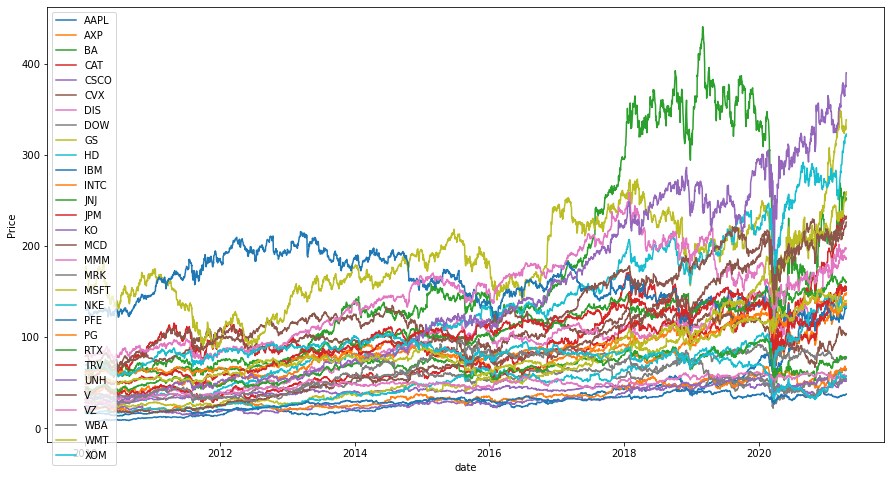

In [5]:
data.plot(x='date',figsize=(15,8))
plt.ylabel('Price')
plt.show()

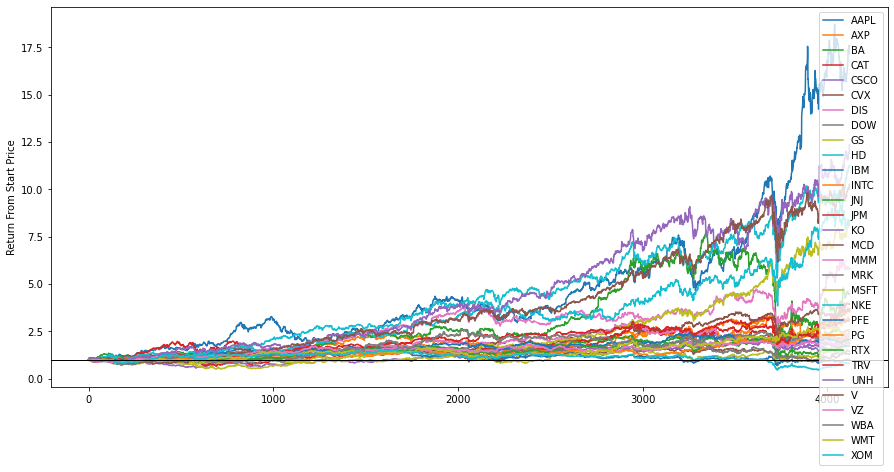

In [6]:
returnfstart = data[data.columns[1:]].apply(lambda x: x / x[0])
returnfstart.plot(figsize=(15,7)).axhline(1, lw=1, color='black')
plt.ylabel('Return From Start Price')
plt.show()

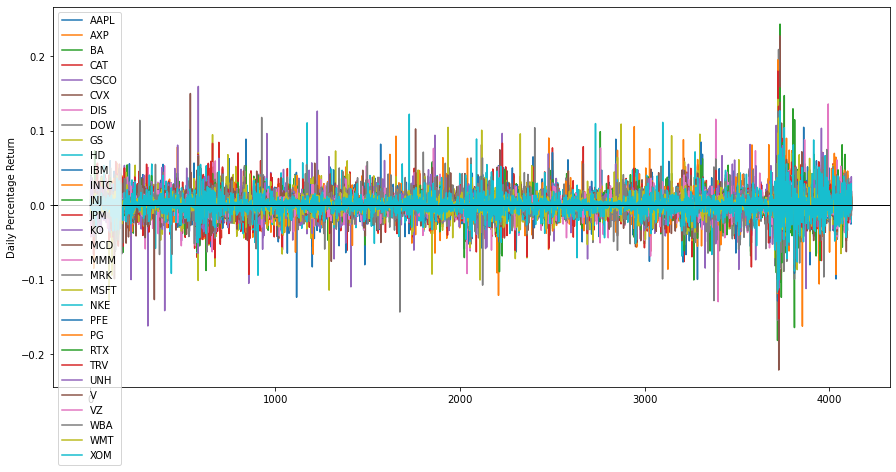

In [7]:
data[data.columns[1:]].pct_change().plot(figsize=(15,7))
plt.axhline(0, color='black', lw=1)
plt.ylabel('Daily Percentage Return')
plt.show()

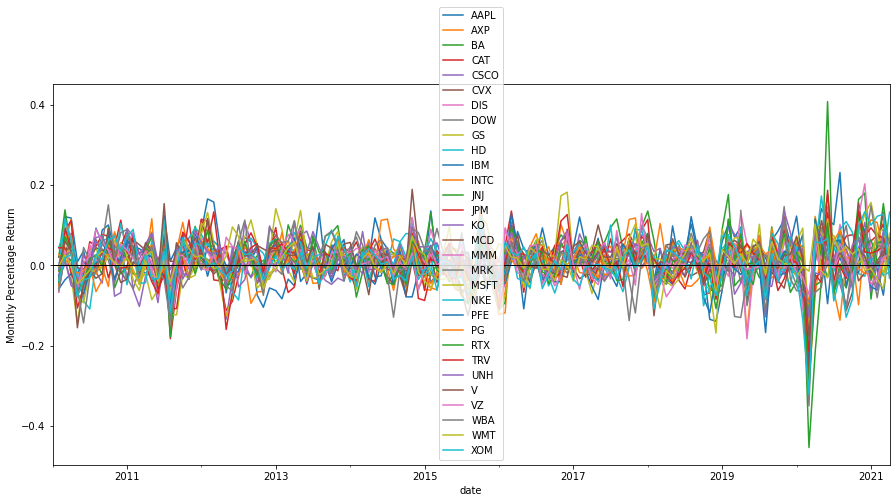

In [8]:
# Resample df to business months, take last observation as value 
data['date'] = pd.to_datetime(data['date'])
monthly = data.groupby(pd.Grouper(key='date', freq='1M')).agg({i:'mean' for i in data.columns[1:]})

# Calculate the monthly percentage change
monthly.pct_change().plot(figsize=(15,7))
plt.axhline(0, color='black', lw=1)
plt.ylabel('Monthly Percentage Return');

# DJ

In [13]:
data['DJ'] = data.mean(axis=1)
data['date'] = pd.to_datetime(data['date'])

train = data.loc[data['date']<datetime(2020,3,1)][['date','DJ']]
test = data.loc[data['date']>=datetime(2020,3,1)][['date','DJ']]

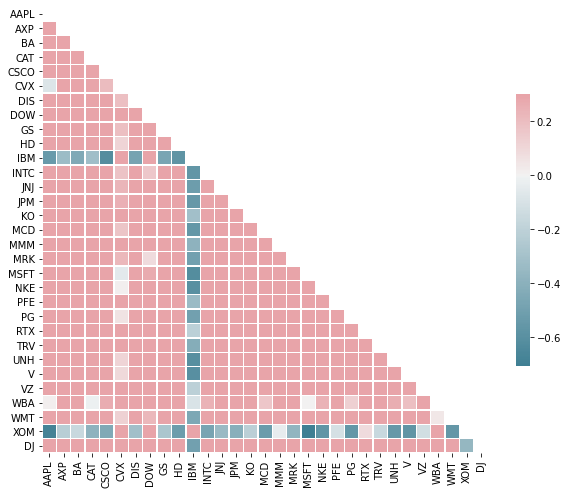

In [14]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

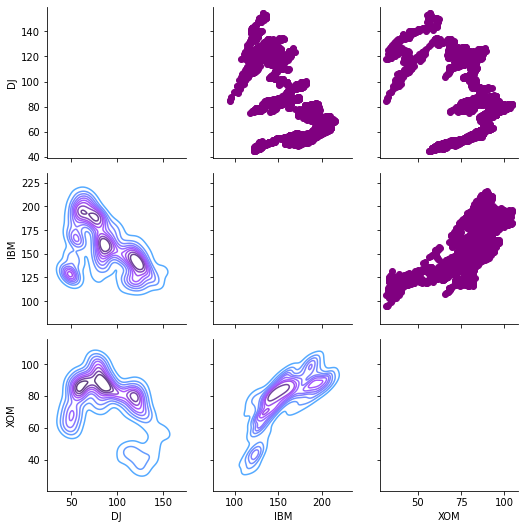

In [99]:
fig = sns.PairGrid(data[['DJ', 'IBM', 'XOM']].dropna())
# define top, bottom and diagonal plots
fig.map_upper(plt.scatter, color='purple')
fig.map_lower(sns.kdeplot, cmap='cool_d')
fig.map_diag(sns.distplot, bins=30)

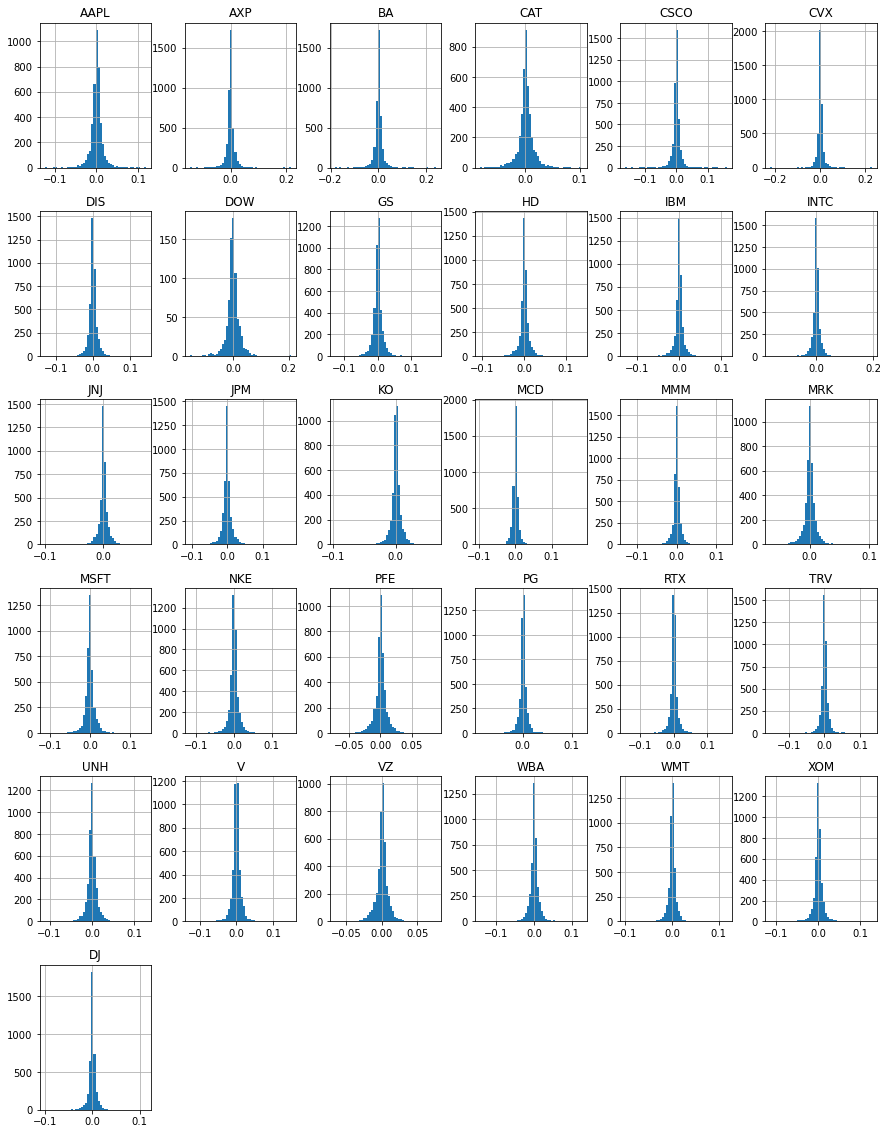

AAPL          AXP           BA          CAT         CSCO  \
count  4120.000000  4120.000000  4120.000000  4120.000000  4120.000000   
mean      0.000788     0.000408     0.000506     0.000433     0.000269   
std       0.013519     0.013814     0.016853     0.014009     0.013337   
min      -0.123558    -0.148187    -0.181507    -0.083722    -0.162107   
25%      -0.004502    -0.003753    -0.004731    -0.004850    -0.003611   
50%       0.001006     0.000259     0.000250     0.000149     0.000391   
75%       0.006126     0.004795     0.005756     0.005998     0.004671   
max       0.119808     0.218823     0.243186     0.103321     0.159505   

               CVX          DIS         DOW           GS           HD  \
count  4120.000000  4120.000000  758.000000  4120.000000  4120.000000   
mean      0.000150     0.000500    0.000610     0.000264     0.000649   
std       0.013005     0.012141    0.023120     0.014206     0.011023   
min      -0.221248    -0.129846   -0.154341    -0.127910    -0.104749   
25%      -0.004010    -0.003687   -0.007894    -0.005029    -0.003154   
50%       0.000242     0.000198    0.000519     0.000508     0.000398   
75%       0.004544     0.004562    0.009804     0.005219     0.004426   
max       0.227407     0.144123    0.209091     0.175803     0.137508   

               IBM         INTC          JNJ          JPM           KO  \
count  4120.000000  4120.000000  4120.000000  4120.000000  4120.000000   
mean      0.000062     0.000375     0.000255     0.000402     0.000188   
std       0.011064     0.014082     0.008264     0.013780     0.008517   
min      -0.128507    -0.162417    -0.100379    -0.105269    -0.096725   
25%      -0.003272    -0.004280    -0.002328    -0.004458    -0.002756   
50%       0.000256     0.000292     0.000152     0.000077     0.000184   
75%       0.003990     0.005296     0.002941     0.004907     0.003320   
max       0.113011     0.195213     0.074412     0.180125     0.064408   

               MCD          MMM          MRK         MSFT          NKE  \
count  4120.000000  4120.000000  4120.000000  4120.000000  4120.000000   
mean      0.000358     0.000266     0.000226     0.000591     0.000589   
std       0.009122     0.010556     0.009907     0.012226     0.012625   
min      -0.096255    -0.129450    -0.066218    -0.113995    -0.116667   
25%      -0.002665    -0.003078    -0.003486    -0.003893    -0.003965   
50%       0.000334     0.000243     0.000000     0.000309     0.000304   
75%       0.003521     0.004061     0.004196     0.004936     0.004733   
max       0.181254     0.125986     0.104080     0.142169     0.151752   

               PFE           PG          RTX          TRV          UNH  \
count  4120.000000  4120.000000  4120.000000  4120.000000  4120.000000   
mean      0.000228     0.000232     0.000206     0.000332     0.000689   
std       0.009849     0.008432     0.012099     0.010677     0.012556   
min      -0.072940    -0.087373    -0.144765    -0.152681    -0.111211   
25%      -0.003315    -0.002684    -0.003537    -0.003207    -0.003754   
50%       0.000000     0.000238     0.000084     0.000351     0.000447   
75%       0.003965     0.003165     0.004145     0.004031     0.004955   
max       0.089607     0.120090     0.157572     0.132903     0.127989   

                 V           VZ          WBA          WMT          XOM  \
count  4120.000000  4120.000000  4120.000000  4120.000000  4120.000000   
mean      0.000642     0.000186     0.000185     0.000273     0.000020   
std       0.012410     0.008638     0.013852     0.009197     0.011573   
min      -0.126722    -0.066205    -0.143374    -0.100405    -0.114340   
25%      -0.003764    -0.003135    -0.004339    -0.002731    -0.003849   
50%       0.000619     0.000206     0.000387     0.000280     0.000000   
75%       0.005032     0.003615     0.004947     0.003668     0.004019   
max       0.149973     0.076802     0.126036     0.117085     0.126868   

                DJ  


In [16]:
daily_pct_c = data.drop(columns=['date']) / data.drop(columns=['date']).shift(1) -1
daily_pct_c.hist(bins=50, figsize=(15,20))
plt.show()

display(daily_pct_c.describe())

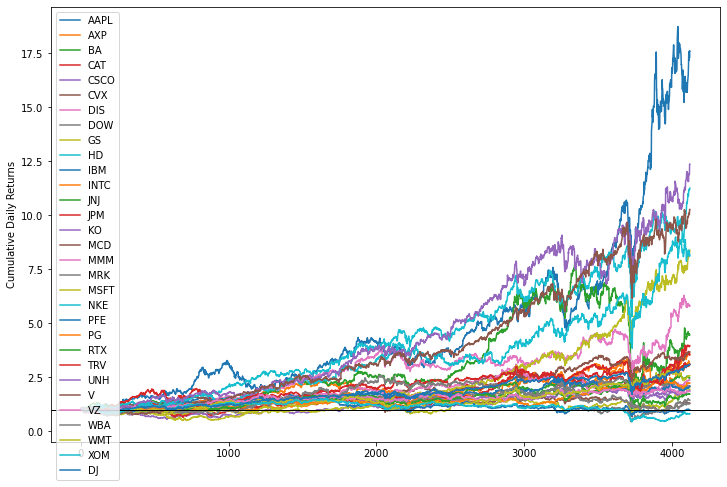

In [17]:
cum_daily_return = (1 + daily_pct_c).cumprod()

cum_daily_return.plot(figsize=(12,8))
plt.ylabel('Cumulative Daily Returns');
plt.axhline(1, color='black', lw=1)
plt.show()

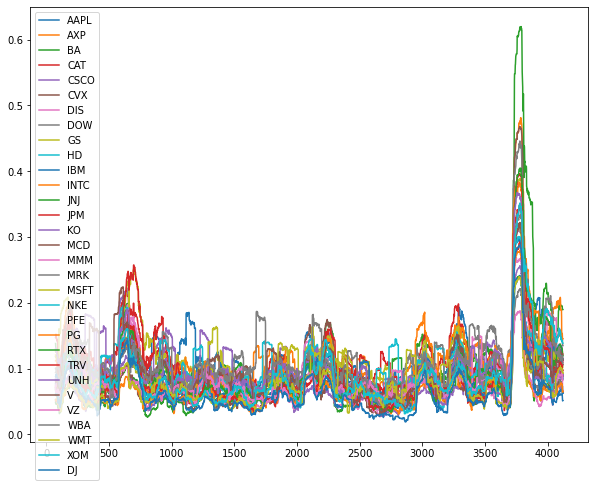

In [18]:
min_periods = 75 

vol = daily_pct_c.rolling(min_periods).std() * np.sqrt(min_periods) 

vol.plot(figsize=(10, 8))
plt.show()

# Seasonality

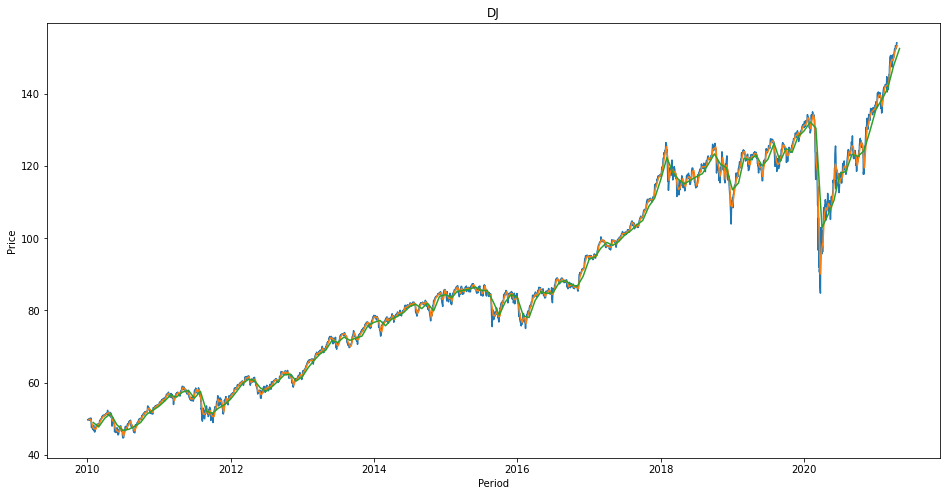

In [19]:
plt.figure(figsize=(16,8))
plt.title('DJ')
plt.xlabel('Period')
plt.ylabel('Price')
plt.plot(data.groupby(pd.Grouper(key='date',freq='1D'))["DJ"].mean().astype('float'), label='daily')
plt.plot(data.groupby(pd.Grouper(key='date',freq='1W'))["DJ"].mean().astype('float'), label='weekly')
plt.plot(data.groupby(pd.Grouper(key='date',freq='1M'))["DJ"].mean().astype('float'), label='monthly')
plt.show()

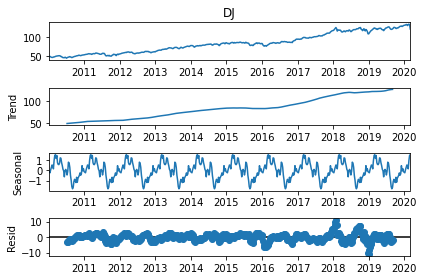

In [20]:
res = sm.tsa.seasonal_decompose(train.groupby(pd.Grouper(key='date',freq='1W'))["DJ"].mean().astype('float'),period=52,model="additive")
fig = res.plot()

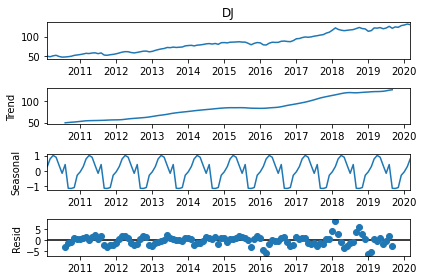

In [21]:
res = sm.tsa.seasonal_decompose(train.groupby(pd.Grouper(key='date',freq='1M'))["DJ"].mean().astype('float'),period=12,model="additive")
fig = res.plot()

# Prophet

In [100]:
from fbprophet import Prophet

In [101]:
ph_df = train.copy().reset_index().rename(columns={'DJ': 'y', 'date': 'ds'})
ph_df['ds'] = pd.to_datetime(ph_df['ds'])

In [102]:
prophet = Prophet(yearly_seasonality=True)
prophet.fit(ph_df)

# Create Future dates
future_prices = prophet.make_future_dataframe(periods=test.shape[0])

# Predict Prices
forecast = prophet.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds        yhat  yhat_lower  yhat_upper
4116 2021-04-12  135.716838  126.117612  144.294867
4117 2021-04-13  135.771029  127.192064  144.019622
4118 2021-04-14  135.812913  125.964266  144.166955
4119 2021-04-15  135.863799  126.102089  143.833219
4120 2021-04-16  135.901133  126.340543  144.578047

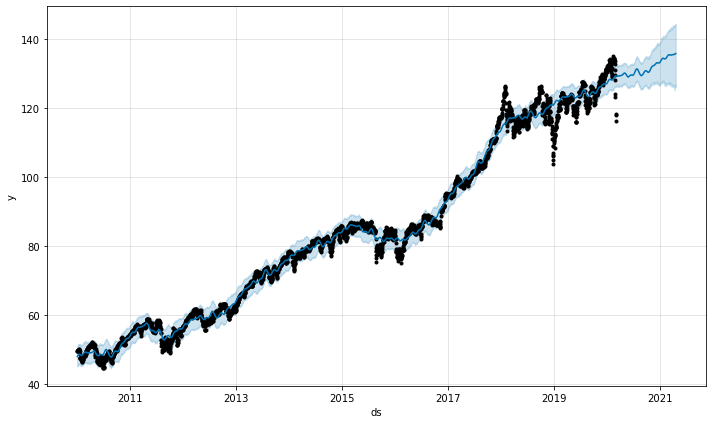

In [104]:
fig1 = prophet.plot(forecast)

In [26]:
calculate_metrics(forecast['yhat'].iloc[:train.shape[0]], train['DJ'])

{'RMSE': 2.647481053184711,
 'RSS': 25996.959333139243,
 'MSE': 7.00915592697203,
 'MAE': 2.022895035094393,
 'R2': 0.9888077848259872}

In [108]:
pd.DataFrame({'Dataset':['train','test'],
 'RMSE': [2.647481053184711, 15.739702245414316],
 'RSS': [25996.959333139243, 102068.14943101179],
 'MSE': [7.00915592697203, 247.738226774301],
 'MAE': [2.022895035094393, 12.585115162149759],
 'R2': [0.9888077848259872, np.nan]})

Dataset       RMSE            RSS         MSE        MAE        R2
0   train   2.647481   25996.959333    7.009156   2.022895  0.988808
1    test  15.739702  102068.149431  247.738227  12.585115       NaN

In [33]:
calculate_metrics(forecast['yhat'].iloc[-test.shape[0]:], test['DJ'])

{'RMSE': 15.739702245414316,
 'RSS': 102068.14943101179,
 'MSE': 247.738226774301,
 'MAE': 12.585115162149759,
 'R2': -0.16444078370945325}

# LSTM

In [82]:
train_ = train['DJ'].values.reshape(-1,1)
test_ = test['DJ'].values.reshape(-1,1)

In [83]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train_)

In [84]:
X_train = []
y_train = []

window = 30

for i in range(window, train.shape[0]):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
    
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [85]:
model = Sequential()

model.add(LSTM(units = 30, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 30, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 30, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 30))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 30)               

In [86]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 64)

Epoch 1/100
58/58 [==============================] - 6s 29ms/step - loss: 0.0776
Epoch 2/100
58/58 [==============================] - 2s 27ms/step - loss: 0.0048
Epoch 3/100
58/58 [==============================] - 2s 28ms/step - loss: 0.0051
Epoch 4/100
58/58 [==============================] - 2s 27ms/step - loss: 0.0037
Epoch 5/100
58/58 [==============================] - 2s 27ms/step - loss: 0.0039
Epoch 6/100
58/58 [==============================] - 2s 27ms/step - loss: 0.0033
Epoch 7/100
58/58 [==============================] - 2s 27ms/step - loss: 0.0033
Epoch 8/100
58/58 [==============================] - 2s 27ms/step - loss: 0.0032
Epoch 9/100
58/58 [==============================] - 2s 27ms/step - loss: 0.0029
Epoch 10/100
58/58 [==============================] - 2s 28ms/step - loss: 0.0032
Epoch 11/100
58/58 [==============================] - 2s 28ms/step - loss: 0.0031
Epoch 12/100
58/58 [==============================] - 2s 28ms/step - loss: 0.0028
Epoch 13/100
58/58 [=====

In [87]:
df_volume = np.vstack((train_, test_))

inputs = df_volume[df_volume.shape[0] - test_.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - train.shape[0] + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [88]:
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

In [94]:
curr_frame = X_test[len(X_test)-1]

future=[]

for i in range(window):
    
    future.append(model.predict(curr_frame[np.newaxis, :, :])[0,0])
    
    curr_frame = np.insert(curr_frame, len(X_test[0]), future[-1], axis=0)
    
    curr_frame = curr_frame[1:]
    
future = sc.inverse_transform(np.array(future).reshape(-1,1))

In [ ]:
calculate_metrics(predict.reshape(1,-1)[0], train['DJ'])

In [95]:
calculate_metrics(predict.reshape(1,-1)[0], test['DJ'])

{'RMSE': 4.26580558725051,
 'RSS': 7497.204090985678,
 'MSE': 18.197097308217668,
 'MAE': 3.036902213122337,
 'R2': 0.9144684188358119}

In [96]:
dates = pd.DataFrame({"date": pd.date_range(start='2021-04-17', end='2021-05-16')})

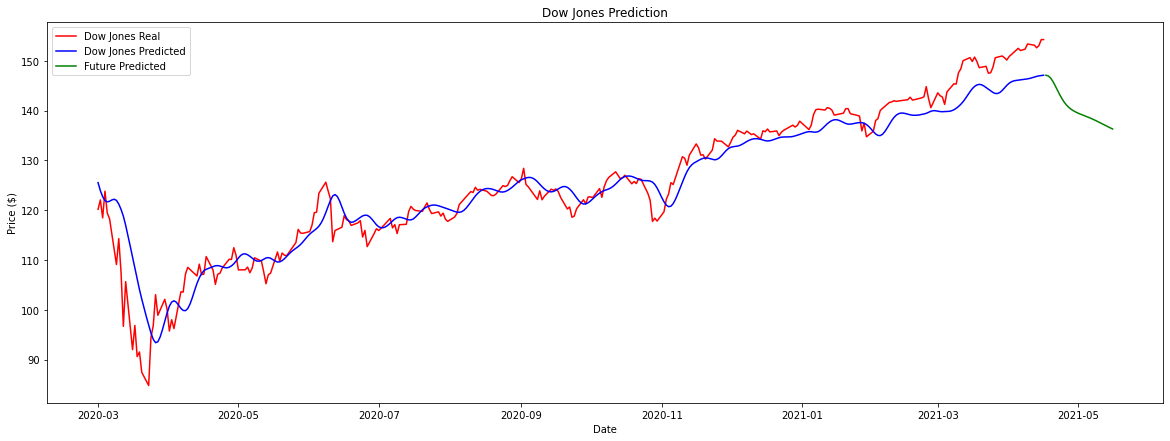

In [160]:
plt.figure(figsize=(20,7))
plt.plot(data['date'].values[train.shape[0]:], df_volume[train.shape[0]:], color = 'red', label = 'Dow Jones Real')
plt.plot(data['date'][-predict.shape[0]:].values, predict, color = 'blue', label = 'Dow Jones Predicted')
plt.plot(dates['date'].values, future, color = 'green', label = 'Future Predicted')
plt.title('Dow Jones Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# LIGHTGBM

In [120]:
df = np.log1p(data[['DJ']])
for i in range(11):
    df['lag_'+str(i)]=df['DJ'].shift(i)

data_train = df.iloc[10:].loc[data['date']<datetime(2020,3,1)]
data_test = df.iloc[10:].loc[data['date']>=datetime(2020,3,1)]

In [121]:
X_train, y_train = data_train[['lag_'+str(i) for i in range(1,11)]], data_train[['lag_0']]
X_test, y_test = data_test[['lag_'+str(i) for i in range(1,11)]], data_test[['lag_0']]

In [122]:
params = {#'max_bin': [i for i in range(2, 100, 1)],
          'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
          'num_leaves': [i for i in range(7, 4095, 10)],
          'num_iterations': [5, 20, 50, 100, 200, 500, 1000],
          'min_data_in_leaf': [i for i in range(1, 200, 10)],
          'feature_fraction': [i*0.1 for i in range(1, 11)],
          'lambda_l1': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
          'lambda_l2': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
          'max_depth': [i for i in range(1, 50, 2)],
          'extra_trees': [True], #[i for i in range(1, 100, 5)],
          'scale_pos_weight': [i for i in range(1, 10000, 100)],
          'min_child_weight': [i*0.01 for i in range(1, 1000, 50)],
          'subsample': [0.4, 1],
          'bagging_freq': [1],
          'colsample_bytree': [0.4, 1],
          }

In [77]:
grid = RandomizedSearchCV(estimator=LGBMRegressor(), param_distributions=params,
                          cv=KFold(), verbose=1, scoring='neg_root_mean_squared_error',
                          n_iter=1000)

grid_results = grid.fit(X_train.copy(), y_train.copy())

clear_output(wait=True)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warnin

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001,

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[L

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 i

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, r

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1,

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambd

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 i

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.00

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[L

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: la

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[Light

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 wi

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: la

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[Light

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ign

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambd

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambd

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lam

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_le

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[Light

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005,

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lam

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Curr

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 i

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1,

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.001, r

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Wa

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignore

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, r

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, r

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignore

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is se

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lam

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Cur

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be igno

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current va

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is se

[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[Light

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: la

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: la

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is se

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[L

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambd

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value:

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambd

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[Lig

[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambd

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: la

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: la

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignore

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Wa

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lam

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=21, min_chi

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 i

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is se

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[Light

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.001, r

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambd

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, r

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[Light

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[Light

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, r

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lam

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[L

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lam

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lam

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[Light

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=161, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=161
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 wi

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=181, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=181
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 i

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_da

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGB

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_la

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[L

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is se

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM]

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[L

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is 

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambd

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=71, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=71
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is se

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=121, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=121
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.00

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[L

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_l

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Curr

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lamb

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[Lig

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=81, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=81
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current v

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. 

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: mi

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005
[LightGBM] [Warning] feature_fraction is set=0.7000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is se

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=1, r

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=171, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=171
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: la

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] lambda_l2 is set=0.005, reg_lambda=0.0 will be ignored. Current value: lambda

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] min_data_in_leaf is set=131, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=131
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 i

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05
[LightGBM] [Warning] min_data_in_leaf is set=151, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=151
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l2 is set=0.05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l2 is set=0.

In [123]:
m = LGBMRegressor(**grid_results.best_params_).fit(X_train, y_train)
preds = m.predict(X_test)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.001, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


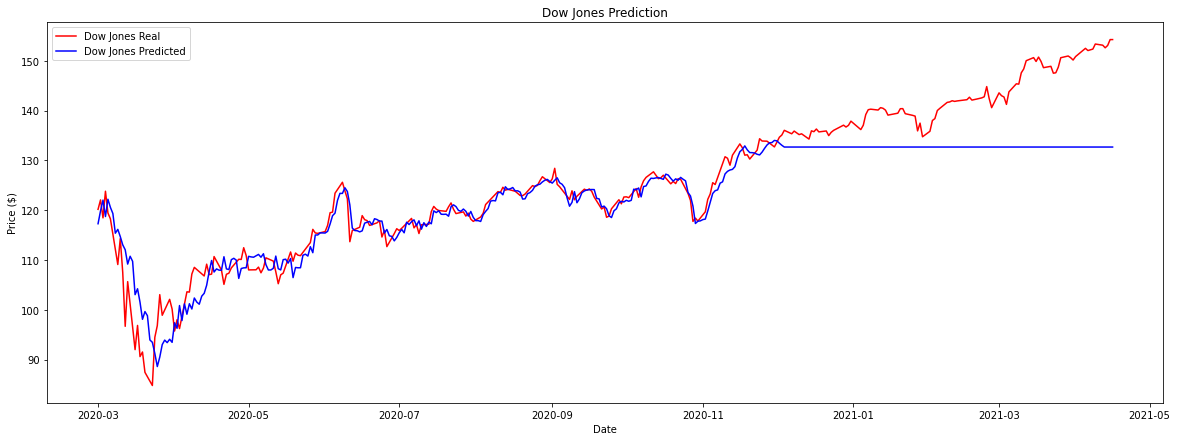

In [148]:
plt.figure(figsize=(20,7))
plt.plot(data['date'].values[train.shape[0]:], df_volume[train.shape[0]:], color = 'red', label = 'Dow Jones Real')
plt.plot(data['date'][-predis.shape[0]:].values, np.expm1(preds).reshape(-1,1), color = 'blue', label = 'Dow Jones Predicted')
plt.title('Dow Jones Prediction')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

In [136]:
calculate_metrics(np.expm1(m.predict(X_train)), y_train['lag_0'].apply(np.expm1))

{'RMSE': 0.8198376835910257,
 'RSS': 2486.2230276853898,
 'MSE': 0.6721338274359011,
 'MAE': 0.5886246881778396,
 'R2': 0.9989242463757685}

In [134]:
calculate_metrics(np.expm1(preds), y_test['lag_0'].apply(np.expm1))

{'RMSE': 7.038389776769394,
 'RSS': 20410.03942768955,
 'MSE': 49.53893064973193,
 'MAE': 4.549219548021654,
 'R2': 0.7671528048739307}

# RESULTS

In [80]:
RESULTS_FINALE = pd.DataFrame({'model':['FBProphet', 'LSTM.30','LightGBM.Best'], 
              'RMSE': [14.01462648855167, 5.492640220338494, 7.035724381200897],
              'RSS': [80920.81931280902, 12429.667795112999, 20394.584038108595],
              'MSE': [196.40975561361424, 30.169096590080123, 49.50141756822476],
              'MAE': [11.234991630866933, 4.060021692315095, 4.594947568078792],
              'R2': [0.07681776553902453, 0.8581965854257769, 0.7673291271258428]})

In [81]:
RESULTS_FINALE

model       RMSE           RSS         MSE        MAE        R2
0      FBProphet  14.014626  80920.819313  196.409756  11.234992  0.076818
1        LSTM.30   5.492640  12429.667795   30.169097   4.060022  0.858197
2  LightGBM.Best   7.035724  20394.584038   49.501418   4.594948  0.767329